Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [340]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
import matplotlib.pyplot as plt

from icecream import ic
from tqdm import tqdm

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [341]:
UNIVERSE_SIZE = 100000
NUM_SETS = 1000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [342]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [343]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [344]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(53835972.66991775))

In [345]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(26545022.225954913))

## Initial Heuristics considerations

If an element is present in one set only, that set must be included in the solution

In [346]:
# Initializes a solution that does not include any set.
initial_solution = np.full(NUM_SETS, False)

# For each element in the universe, if there is only one set that includes
# that element, adds that set to the initial solution.
for s in range(UNIVERSE_SIZE):
    if np.count_nonzero(SETS[:, s]) > 1:
        continue
    
    set_idx = np.argwhere(SETS[:, s] == True)
    solution[set_idx] = True

# Saves the initial solution (containing only the mandatory sets)
mandatory_sets = initial_solution

## Random Mutation Hill Climber

We run a RMHC algorithm, preserving the mandatory sets.

To evaluate the fitness, we check the number of elements included in the solution and the cost of the solution (in order).

100%|██████████| 10000/10000 [03:05<00:00, 53.95it/s]


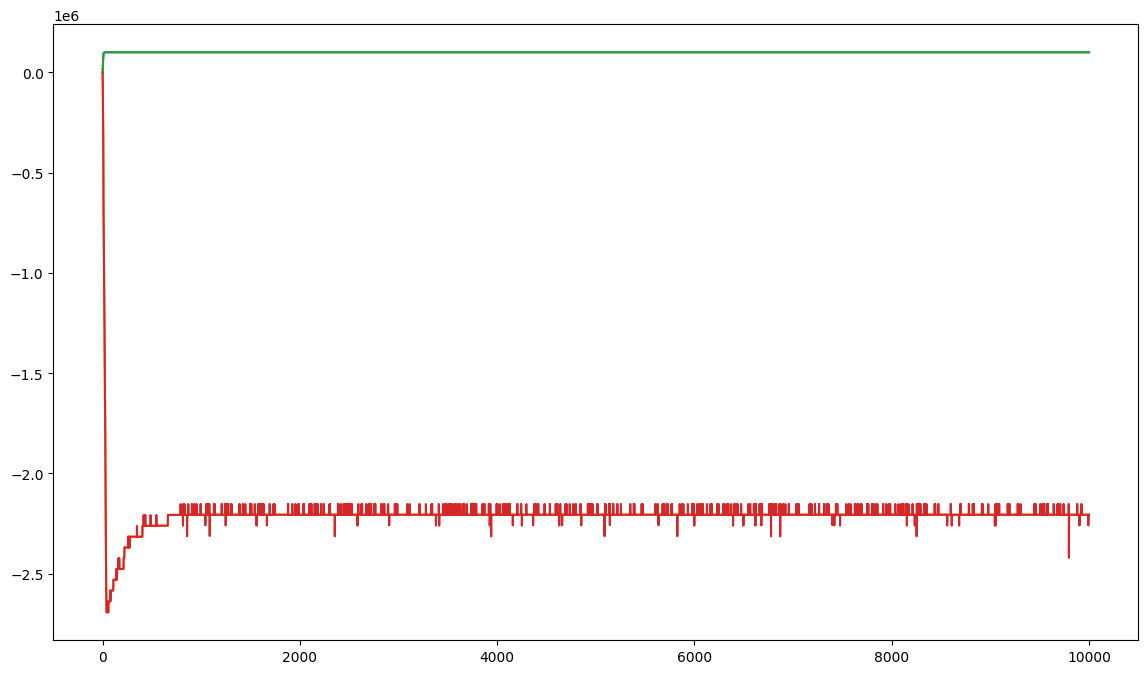

(100000, np.float64(-2206252.1803228525))

In [347]:
# The number of iterations the algorithm will perform.
NUM_STEPS = 10000

# The function used to tweak a solution.
def tweak(intermediate_solution):
    # Check for sets that can be changed.
    # If no set can be changed (i.e. all sets are mandatory), return the unchanged solution.
    non_mandatory_indexes = np.argwhere(mandatory_sets == False)
    if non_mandatory_indexes.size == 0:
        return intermediate_solution

    # Changes a number of sets to the solution, with a (small) probability of changing a new
    # set decreasing with the number of sets already changed in the same step.
    # If the solution is already a valid one, starts excluding sets to reduce the cost.
    index = None
    while index is None or rng.random() < 0.3:
        index = rng.choice(non_mandatory_indexes)
        intermediate_solution[index] = not valid(intermediate_solution)
        
    return intermediate_solution

# The function used to evaluate the fitness of a solution.
def fitness(intermediate_solution):
    intermediate_solution_cost = cost(intermediate_solution)
    intermediate_solution_coverage = np.count_nonzero(np.count_nonzero(SETS[intermediate_solution], axis=0))
    
    return intermediate_solution_coverage, -intermediate_solution_cost

# Initializes the solution to be improved
current_solution = initial_solution
# Initializes a list containing the history of fitness of
# the intermediate solutions
history = [fitness(current_solution)]

# Applies the Hill Climber algorithm
for step in tqdm(range(NUM_STEPS)):
    new_solution = tweak(current_solution.copy())
    history.append(fitness(new_solution))

    if fitness(new_solution) > fitness(current_solution):
        current_solution = new_solution
        
# Plots the history of fitness of the intermediate solutions.
plt.figure(figsize=(14,8))
plt.plot(range(len(history)), list(accumulate(history, max)))
plt.plot(range(len(history)), history)
plt.show()

fitness(current_solution)

## RMHC with reset on best fitness plateau

If the best solution has not changed in a while, resets the solution to the initial solution (i.e. the one containing only the mandatory sets).
It also increases the probability of changing a larger number of sets in a single tweak (exploration).

In [348]:
# The number of iterations the algorithm will perform.
NUM_STEPS = 10000


# The function used to tweak a solution.
def tweak(intermediate_solution):
    # Check for sets that can be changed.
    # If no set can be changed (i.e. all sets are mandatory), return the unchanged solution.
    non_mandatory_indexes = np.argwhere(mandatory_sets == False)
    if non_mandatory_indexes.size == 0:
        return intermediate_solution

    # Changes a number of sets to the solution, with a probability of changing a new
    # set decreasing with the number of sets already changed in the same step.
    # If the solution is already a valid one, starts excluding  sets to reduce the cost.
    index = None
    while index is None or rng.random() < 0.3 + len(solutions) / 25000:
        index = rng.choice(non_mandatory_indexes)
        intermediate_solution[index] = not valid(intermediate_solution)

    return intermediate_solution


# The function used to evaluate the fitness of a solution.
def fitness(intermediate_solution):
    intermediate_solution_cost = cost(intermediate_solution)
    intermediate_solution_coverage = np.count_nonzero(np.count_nonzero(SETS[intermediate_solution], axis=0))

    return intermediate_solution_coverage, -intermediate_solution_cost


# Initializes the solution to be improved
cur_solution = initial_solution
solutions = []
# Initializes a list containing the history of fitness of
# the intermediate solutions
history = [fitness(cur_solution)]
histories = [history]

# Applies the Hill Climber algorithm
for step in tqdm(range(NUM_STEPS)):
    new_solution = tweak(cur_solution.copy())
    history.append(fitness(new_solution))

    if fitness(new_solution) > fitness(cur_solution):
        cur_solution = new_solution

    if step - list(accumulate(histories[-1], max)).index(fitness(cur_solution)) > NUM_STEPS // 10:
        solutions.append(cur_solution)
        cur_solution = initial_solution
        history = [fitness(cur_solution)]
        histories.append(history)

max([fitness(solution) for solution in solutions])

100%|██████████| 10000/10000 [00:53<00:00, 185.88it/s]


(100000, np.float64(-2152456.6786956503))